In [1]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb #xgboost model
import pmdarima as pm

%matplotlib inline

In [2]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Filtrado por solo 1 producto

In [100]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase2.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

dataset=dataset[dataset['Producto']==1]

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
2,2015-07-01,1,16070,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0


In [22]:
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
5,2015-07-04,1,0,0,4.394742,0,1
...,...,...,...,...,...,...,...
1890,2020-08-26,1,0,0,3.910500,0,0
1892,2020-08-28,1,0,0,4.394742,0,0
1893,2020-08-29,1,0,0,4.394742,0,1
1894,2020-08-30,1,0,0,4.394742,0,1


In [87]:
Q1_ventas=dataset['udsVenta'].quantile(0.25)
Q3_ventas=dataset['udsVenta'].quantile(0.75)
IQR_ventas=Q3_ventas-Q1_ventas

Limit_lower=Q1_ventas-(1.5*IQR_ventas)
Limit_upper=Q3_ventas+(1.5*IQR_ventas)

dataset=dataset[~((dataset["udsVenta"] < Limit_lower) |(dataset["udsVenta"] > Limit_upper))]


Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [88]:
dataset=dataset.set_index('Fecha')

<ipython-input-89-8e0042ee2c45>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  fig = seasonal_decompose(dataset['udsVenta'], model='additive', freq=365).plot()


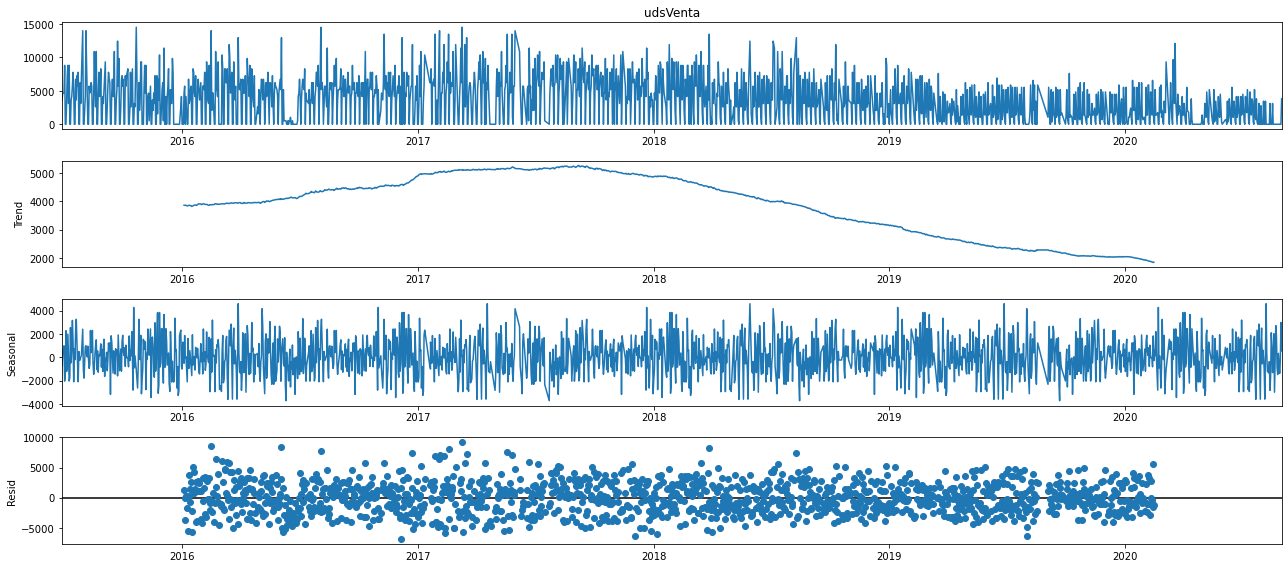

In [89]:

from statsmodels.tsa.seasonal import seasonal_decompose

fig = seasonal_decompose(dataset['udsVenta'], model='additive', freq=365).plot()

In [90]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(dataset['udsVenta'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -2.438004
p-value                           0.131296
#Lags Used                       25.000000
Number of Observations Used    1719.000000
Critical Value (1%)              -3.434160
Critical Value (5%)              -2.863223
Critical Value (10%)             -2.567666
dtype: float64

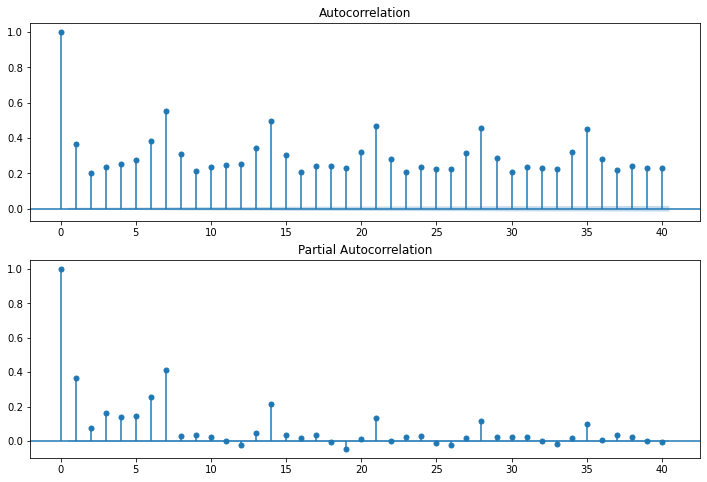

In [61]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['udsVenta'], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['udsVenta'], lags=40, ax=ax2)# , lags=40

In [91]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [92]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset['udsVenta'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:34593.00533783533
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:33998.22968352231
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:34029.49539625503


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:32716.07358377067
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:33642.29640674987


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:32893.50899915352


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:33259.89614009714


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:32593.60609068193
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:34063.1469184971


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:33710.56336904147


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:34010.87159055398


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:32927.758801269854
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:33667.23621688498


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:33256.56821999183


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:33259.81804194144


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:32921.537333666565
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:34073.315674759906
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:33810.09505053262


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:35245.58705470865


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:33932.17148700659
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:33829.52702625948


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:33812.178822202666


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:34387.24656021183


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:33745.66451196303
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:32966.11668047122


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:32726.489236806177


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:34099.212693396636


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:33236.908923774026


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:32763.981609413386


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:32655.77000313963


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:33571.808478009676


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:33233.3030572845
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:33731.67260692029


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:33495.71472238982
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:34030.72533873697


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:32945.39727866005
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:33493.436152266346

C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:32966.55466896987


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:33240.167427568354


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:32939.24041706491


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:33011.59324053065


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:32757.917343695713


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:33872.0308754123


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:32912.1910016007


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:32777.38516430682


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:32758.797700251773


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:33264.226253816756


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:33788.10641109522


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:33509.10664671917
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:35009.72380124402


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:33810.57700247465
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:33511.237795897745


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:33510.991941580694


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:34223.52488292448


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:33792.66662537955


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:32956.231056099714


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:32716.250497883997


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:34090.76993300064


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:33216.57683970011


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:32735.58522371865


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:32717.199430018154


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:33536.404901866095


C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:33212.854656266005


In [93]:
#FULL-->SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685
#PROD=1-->SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685
y_train=dataset['udsVenta']

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7226      0.063    -11.501      0.000      -0.846      -0.599
ma.L1          0.8241      0.050     16.479      0.000       0.726       0.922
ar.S.L12      -0.0858      0.026     -3.338      0.001      -0.136      -0.035
ma.S.L12      -0.9020      0.012    -74.294      0.000      -0.926      -0.878
sigma2      9.624e+06   3.39e-10   2.84e+16      0.000    9.62e+06    9.62e+06


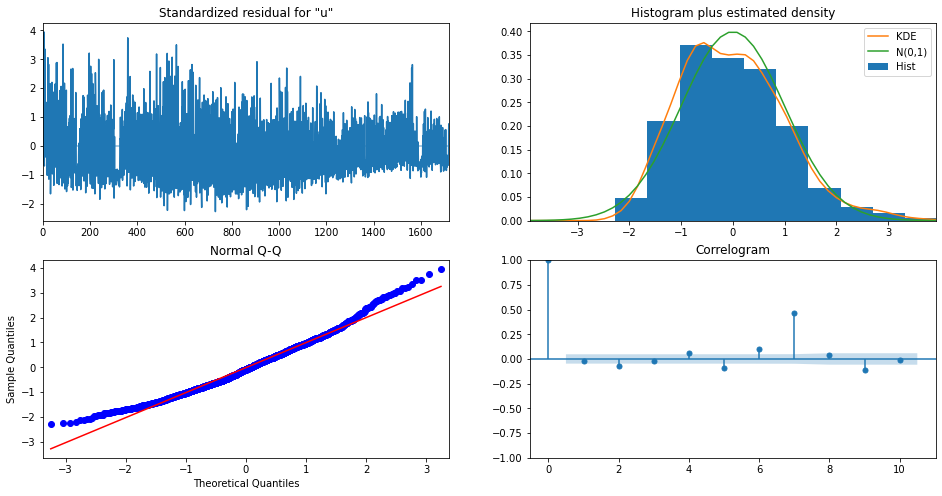

In [94]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

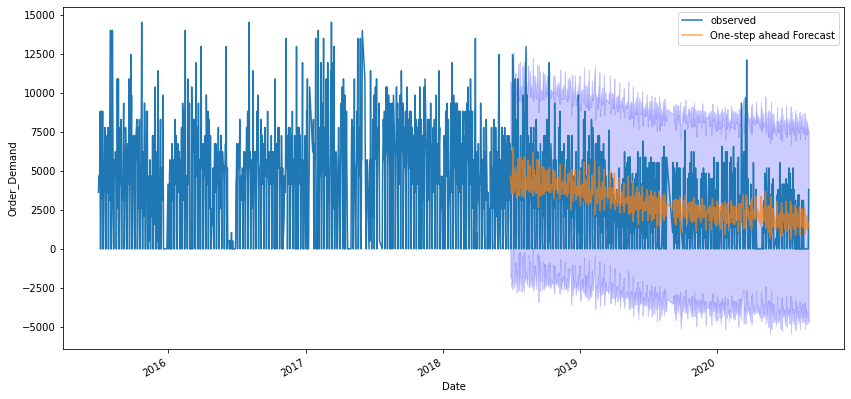

In [95]:
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2018-06-29'), dynamic=False) #false is when using the entire history.
#pred = results.get_prediction(dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y_train['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [99]:
#Getting the mean squared error (average error of forecasts).
pred = results.get_prediction(start=pd.to_datetime('2019-06-29'), dynamic=False)

y_forecasted = pred.predicted_mean
#y_truth = y_train['2016-01-01':]
y_truth = y_train['2019-06-29':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 4547333.12


In [97]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 2132.45


In [81]:
pred.predicted_mean

Fecha
2019-06-29    436.310409
2019-06-30    201.924331
2019-07-02    422.873120
2019-07-03    607.804279
2019-07-06    503.868947
                 ...    
2021-03-19     33.099356
2021-03-20    305.025946
2021-03-21     63.891520
2021-03-22    220.544773
2021-03-23    145.713288
Name: predicted_mean, Length: 120169, dtype: float64

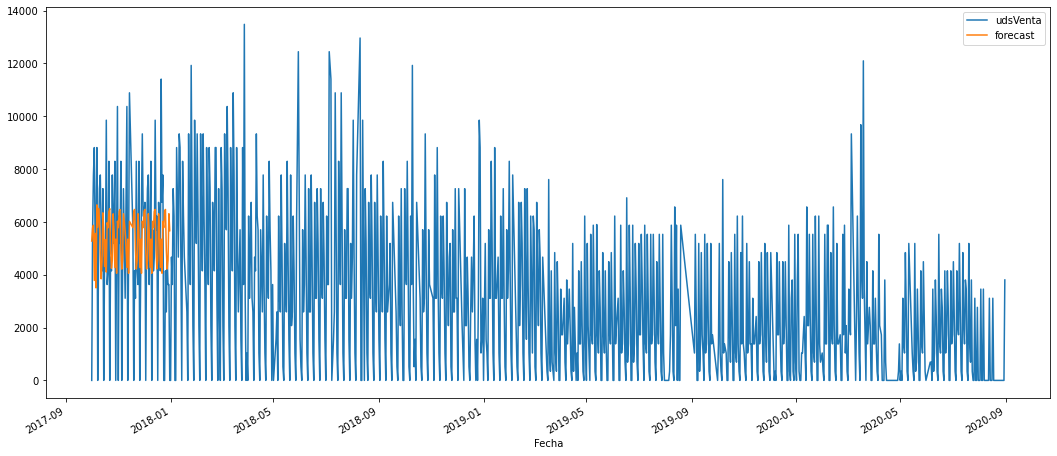

In [98]:
dataset['forecast'] = results.predict(start='2017-10-01', end='2017-12-31', dynamic=True)
dataset[['udsVenta', 'forecast']].loc['2017-10-01':].plot();

In [84]:
y_forecasted

In [ ]:
y_truth

# Full dataset

In [100]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase2.xlsx',parse_dates=True)
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset



,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
2,2015-07-01,1,16070,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0


In [101]:
Q1_ventas=dataset['udsVenta'].quantile(0.25)
Q3_ventas=dataset['udsVenta'].quantile(0.75)
IQR_ventas=Q3_ventas-Q1_ventas

Limit_lower=Q1_ventas-(1.5*IQR_ventas)
Limit_upper=Q3_ventas+(1.5*IQR_ventas)

dataset=dataset[~((dataset["udsVenta"] < Limit_lower) |(dataset["udsVenta"] > Limit_upper))]


Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [102]:
dataset=dataset.set_index('Fecha')

<ipython-input-103-8e0042ee2c45>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  fig = seasonal_decompose(dataset['udsVenta'], model='additive', freq=365).plot()


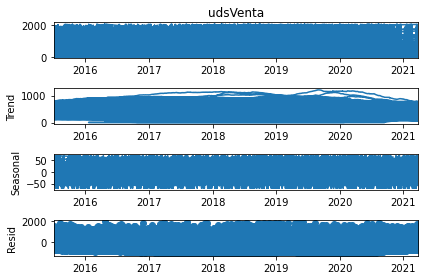

In [103]:

from statsmodels.tsa.seasonal import seasonal_decompose

fig = seasonal_decompose(dataset['udsVenta'], model='additive', freq=365).plot()

In [104]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(dataset['udsVenta'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.013413e+01
p-value                        8.760019e-18
#Lags Used                     7.100000e+01
Number of Observations Used    1.205270e+05
Critical Value (1%)           -3.430404e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64

In [105]:
#FULL-->SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685
#PROD=1-->SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685
y_train=dataset['udsVenta']

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2369      0.010    -24.121      0.000      -0.256      -0.218
ma.L1          0.4181      0.009     45.478      0.000       0.400       0.436
ar.S.L12      -0.0101      0.002     -4.649      0.000      -0.014      -0.006
ma.S.L12      -0.9505      0.001  -1319.055      0.000      -0.952      -0.949
sigma2      1.788e+05    602.252    296.941      0.000    1.78e+05     1.8e+05


In [54]:
check_df(X_train)

##################### Shape #####################
(94757, 7)
##################### Types #####################
Producto           int64
udsVenta           int64
flag               int64
Precio           float64
Festivo            int64
Fin de semana      int64
predict          float64
dtype: object
##################### Head #####################
            Producto  udsVenta  flag    Precio  Festivo  Fin de semana  \
Fecha                                                                    
2015-07-04         1         0     0  4.394742        0              1   
2015-07-05         1         0     0  4.394742        0              1   
2015-07-11         1         0     0  4.394742        0              1   

            predict  
Fecha                
2015-07-04      NaN  
2015-07-05      NaN  
2015-07-11      NaN  
##################### Tail #####################
            Producto  udsVenta  flag    Precio  Festivo  Fin de semana  \
Fecha                                          

In [41]:
#FULL-->SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1793957.9666067457
#PROD=1-->SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:32553.20152924685


from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\subir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0624      0.002     26.460      0.000       0.058       0.067
ma.L1         -0.9733      0.001  -1681.965      0.000      -0.974      -0.972
ar.S.L12       0.4174      0.020     20.872      0.000       0.378       0.457
ma.S.L12      -0.4999      0.019    -26.384      0.000      -0.537      -0.463
sigma2       1.68e+05    635.169    264.555      0.000    1.67e+05    1.69e+05


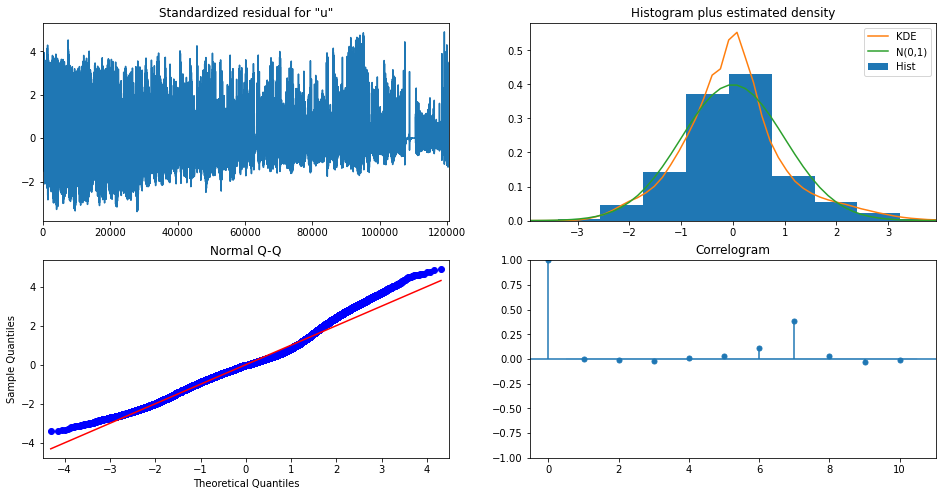

In [106]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

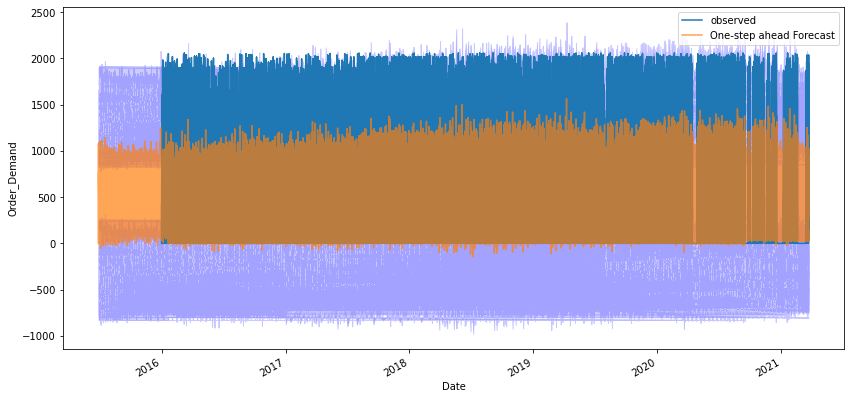

In [111]:
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False) #false is when using the entire history.
#pred = results.get_prediction(start=pd.to_datetime('2018-06-29'), dynamic=False) #false is when using the entire history.
#pred = results.get_prediction(dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
#ax = y_train['2015':].plot(label='observed')
ax = y_train['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()


In [115]:
#Getting the mean squared error (average error of forecasts).
#pred = results.get_prediction(start=pd.to_datetime('2019-06-29'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2019-06-29'), dynamic=False)

y_forecasted = pred.predicted_mean

#y_truth = y_train['2016-01-01':]
#y_truth = y_train['2019-06-29':]
y_truth = y_train['2019-06-29':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 304210.38


In [116]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 551.55


In [112]:
y_forecasted

Fecha
2019-06-29    436.310409
2019-06-30    201.924331
2019-07-02    422.873120
2019-07-03    607.804279
2019-07-06    503.868947
                 ...    
2021-03-19     33.099356
2021-03-20    305.025946
2021-03-21     63.891520
2021-03-22    220.544773
2021-03-23    145.713288
Name: predicted_mean, Length: 120169, dtype: float64

In [113]:
y_truth

Fecha
2019-06-29     691
2019-06-30       0
2019-07-02    1728
2019-07-03    1728
2019-07-06    1382
              ... 
2021-03-19     540
2021-03-20       0
2021-03-21       0
2021-03-22       0
2021-03-23     162
Name: udsVenta, Length: 36974, dtype: int64

In [ ]:
#https://www.kaggle.com/imsanjoykb/forecast-order-demand-and-visualization